# Conversion of EQTransformer models to seisbench

This notebook is adapted from an original notebook developed by the seisbench team [here](https://github.com/seisbench/seisbench/blob/main/contrib/model_conversion/eqtransformer_conversion.ipynb) and updated for the two models distributed by EQTransformer [here](https://github.com/smousavi05/EQTransformer/tree/master/ModelsAndSampleData). This notebook converts from tensorflow models to py-torch models within the seisbench framework.

## Requirements

To run this notebook you will need seisbench installed alongside keras and tensorflow. You will also need to download the two models from [here](https://github.com/smousavi05/EQTransformer/tree/master/ModelsAndSampleData).

**Last run on 10/06/2022** - note that this notebook will not be kept up to date with changes made to EQTransformer or seisbench.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from seisbench.models import EQTransformer
from seisbench.models.eqtransformer import CustomLSTM, ActivationLSTMCell
import torch
import torch.nn as nn
import h5py
import numpy as np
import matplotlib.pyplot as plt
import keras.backend as K
import tensorflow as tf
from keras.models import Sequential

import os
from tempfile import NamedTemporaryFile
import urllib.request

In [3]:
def traverse(root):
    if isinstance(root, h5py.Dataset):
        return {root.name: root[()]}
    else:
        out = {}
        for key in root.keys():
            out.update(traverse(root[key]))
        return out

def list_weights(path_or_url):
    """
    Lists the weights and their shapes in a hdf5 file
    :return: dict[weight_path, shape]
    """
    if os.path.isfile(path_or_url):
        path = path_or_url
    elif "://" in path_or_url[:10]:
        # URL - download
        path = NamedTemporaryFile().name
        urllib.request.urlretrieve(path_or_url, path)
    else:
        raise Exception(f"{path_or_url} doesn't look like a url or file location")
    with h5py.File(path, "r") as f:
        return traverse(f["model_weights"])

Download and list the weights of the EQTransformer model - **Note:** Change this to the model that is required - any updates to EQTransfromer archtecture is likely to break this.

In [4]:
tf_state_dict = list_weights(
    "https://github.com/smousavi05/EQTransformer/"
    "raw/master/ModelsAndSampleData/"
    "EqT_original_model.h5")

Load an empty seisbench model - note that the models distributed by EQTransformer have two LSTM blocks

In [5]:
model = EQTransformer(original_compatible="non-conservative", lstm_blocks=2)
wv = torch.rand(20, 3, 6000, device=model.device)
# det, p, s = model(wv)

In [6]:
print("Total number of param vectors:", len(list(model.parameters())))
print("Total number of params:", sum(p.numel() for p in model.parameters()))

Total number of param vectors: 186
Total number of params: 372023


In [6]:
pt_state_dict = model.state_dict()

In [7]:
def compare_dicts_by_shape(a, b):
    """
    Finds all entries of a that do not have a shape equivalent in b and vice versa
    """
    
    a_shapes = set(tuple(x.shape) for x in a.values())
    b_shapes = set(tuple(x.shape) for x in b.values())
    
    print('A but not B')
    for key, val in a.items():
        if tuple(val.shape) not in b_shapes:
            print(key, val.shape)
            
    print()
    print('B but not A')
    for key, val in b.items():
        if tuple(val.shape) not in a_shapes:
            print(key, val.shape)

In [8]:
compare_dicts_by_shape(tf_state_dict, pt_state_dict)

A but not B
/model_weights/bidirectional_1/bidirectional_1/backward_lstm_1/recurrent_kernel:0 (16, 64)
/model_weights/bidirectional_1/bidirectional_1/forward_lstm_1/recurrent_kernel:0 (16, 64)
/model_weights/bidirectional_2/bidirectional_2/backward_lstm_2/kernel:0 (16, 64)
/model_weights/bidirectional_2/bidirectional_2/backward_lstm_2/recurrent_kernel:0 (16, 64)
/model_weights/bidirectional_2/bidirectional_2/forward_lstm_2/kernel:0 (16, 64)
/model_weights/bidirectional_2/bidirectional_2/forward_lstm_2/recurrent_kernel:0 (16, 64)
/model_weights/conv1d_1/conv1d_1/kernel:0 (11, 3, 8)
/model_weights/conv1d_10/conv1d_10/kernel:0 (3, 64, 64)
/model_weights/conv1d_11/conv1d_11/kernel:0 (3, 64, 64)
/model_weights/conv1d_12/conv1d_12/kernel:0 (3, 64, 64)
/model_weights/conv1d_13/conv1d_13/kernel:0 (3, 64, 64)
/model_weights/conv1d_14/conv1d_14/kernel:0 (3, 64, 64)
/model_weights/conv1d_15/conv1d_15/kernel:0 (3, 64, 64)
/model_weights/conv1d_16/conv1d_16/kernel:0 (2, 64, 64)
/model_weights/conv1

In [9]:
lstm = model.bi_lstm_stack.members[0].lstm

In [10]:
lstm_dict = lstm.state_dict()
for key, val in lstm_dict.items():
    print(key, tuple(val.shape))

cell_f.weight_ih (64, 64)
cell_f.weight_hh (64, 16)
cell_f.bias_ih (64,)
cell_f.bias_hh (64,)
cell_b.weight_ih (64, 64)
cell_b.weight_hh (64, 16)
cell_b.bias_ih (64,)
cell_b.bias_hh (64,)


In [11]:
new_state_dict = {}

In [12]:
# Copy encoder

for key in model.encoder.state_dict():
    _, conv_id, t = key.split('.')
    
    conv_id = int(conv_id) + 1
    
    source = f"/model_weights/conv1d_{conv_id}/conv1d_{conv_id}/"
    if t == "weight":
        data = np.transpose(tf_state_dict[source + "kernel:0"], (2, 1, 0))
        # For input layer, resort channels from ENZ to ZNE
        if conv_id == 1:
            data = data[:, [2, 1, 0], :]
            
    elif t == "bias":
        data = tf_state_dict[source + "bias:0"]
        
    new_state_dict["encoder." + key] = torch.tensor(data)

In [13]:
# Copy res CNN

norm_dict = {'weight': 'gamma',
             'bias': 'beta',
             'running_mean': 'moving_mean',
             'running_var': 'moving_variance'}

for key in model.res_cnn_stack.state_dict():
    _, member_id, layer, t = key.split('.')
    
    if layer[:4] == "conv":
        conv_id = 7 + 2 * int(member_id) + int(layer[-1:])
        source = f"/model_weights/conv1d_{conv_id}/conv1d_{conv_id}/"
        print(f"Copying {source} to {key}")
        if t == "weight":
            data = np.transpose(tf_state_dict[source + "kernel:0"], (2, 1, 0))
        elif t == "bias":
            data = tf_state_dict[source + "bias:0"]
        
    elif layer[:4] == "norm":
        norm_id = 2 * int(member_id) + int(layer[-1:])
        if t == 'num_batches_tracked':
            data = model.res_cnn_stack.state_dict()[key]
        else:
            source = f"/model_weights/batch_normalization_{norm_id}/batch_normalization_{norm_id}/{norm_dict[t]}:0"
            print(f"Copying {source} to {key}")
            data = tf_state_dict[source]
        
    out_key = "res_cnn_stack." + key
    new_state_dict[out_key] = torch.tensor(data)
    # print(data.shape, model.res_cnn_stack.state_dict()[key].shape)

Copying /model_weights/batch_normalization_1/batch_normalization_1/gamma:0 to members.0.norm1.weight
Copying /model_weights/batch_normalization_1/batch_normalization_1/beta:0 to members.0.norm1.bias
Copying /model_weights/batch_normalization_1/batch_normalization_1/moving_mean:0 to members.0.norm1.running_mean
Copying /model_weights/batch_normalization_1/batch_normalization_1/moving_variance:0 to members.0.norm1.running_var
Copying /model_weights/conv1d_8/conv1d_8/ to members.0.conv1.weight
Copying /model_weights/conv1d_8/conv1d_8/ to members.0.conv1.bias
Copying /model_weights/batch_normalization_2/batch_normalization_2/gamma:0 to members.0.norm2.weight
Copying /model_weights/batch_normalization_2/batch_normalization_2/beta:0 to members.0.norm2.bias
Copying /model_weights/batch_normalization_2/batch_normalization_2/moving_mean:0 to members.0.norm2.running_mean
Copying /model_weights/batch_normalization_2/batch_normalization_2/moving_variance:0 to members.0.norm2.running_var
Copying /m

/tmp/ipykernel_15754/1134306714.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  new_state_dict[out_key] = torch.tensor(data)


In [14]:
# Copy BiLSTMStack

for key in model.bi_lstm_stack.state_dict():
    parts = key.split('.')
    print(parts)
    if len(parts) == 4:
        _, member_id, layer, t = key.split('.')
    else:
        _, member_id, layer, cell, t = key.split('.')
    
    if layer == "conv":
        conv_id = 22 + int(member_id)
        source = f"/model_weights/conv1d_{conv_id}/conv1d_{conv_id}/"
        if t == "weight":
            data = np.transpose(tf_state_dict[source + "kernel:0"], (2, 1, 0))
        elif t == "bias":
            data = tf_state_dict[source + "bias:0"]
            
    elif layer == "norm":
        norm_id = 15 + int(member_id)
        if t == 'num_batches_tracked':
            data = model.bi_lstm_stack.state_dict()[key]
        else:
            source = f"/model_weights/batch_normalization_{norm_id}/batch_normalization_{norm_id}/{norm_dict[t]}:0"
            data = tf_state_dict[source]
            
    elif layer == "lstm":
        if cell[-1] == "f":
            direction = "forward"
        else:
            direction = "backward"
        lstm_id = int(member_id) + 1
        
        source = f"/model_weights/bidirectional_{lstm_id}/bidirectional_{lstm_id}/{direction}_lstm_{lstm_id}/"
        
        # Split bias 0.5/0.5
        # https://stackoverflow.com/questions/55229636/import-lstm-from-tensorflow-to-pytorch-by-hand
        if t.startswith("weight_ih"):
            data = tf_state_dict[source + "kernel:0"].T
        elif t.startswith("weight_hh"):
            data = tf_state_dict[source + "recurrent_kernel:0"].T
        elif t.startswith("bias_hh"):
            data = 0.5 * tf_state_dict[source + "bias:0"]
        else:
            # bias_ih
            data = 0.5 * tf_state_dict[source + "bias:0"]
            
    print(f"Copying {source} to {key}")
    out_key = "bi_lstm_stack." + key
    new_state_dict[out_key] = torch.tensor(data)

['members', '0', 'lstm', 'cell_f', 'weight_ih']
Copying /model_weights/bidirectional_1/bidirectional_1/forward_lstm_1/ to members.0.lstm.cell_f.weight_ih
['members', '0', 'lstm', 'cell_f', 'weight_hh']
Copying /model_weights/bidirectional_1/bidirectional_1/forward_lstm_1/ to members.0.lstm.cell_f.weight_hh
['members', '0', 'lstm', 'cell_f', 'bias_ih']
Copying /model_weights/bidirectional_1/bidirectional_1/forward_lstm_1/ to members.0.lstm.cell_f.bias_ih
['members', '0', 'lstm', 'cell_f', 'bias_hh']
Copying /model_weights/bidirectional_1/bidirectional_1/forward_lstm_1/ to members.0.lstm.cell_f.bias_hh
['members', '0', 'lstm', 'cell_b', 'weight_ih']
Copying /model_weights/bidirectional_1/bidirectional_1/backward_lstm_1/ to members.0.lstm.cell_b.weight_ih
['members', '0', 'lstm', 'cell_b', 'weight_hh']
Copying /model_weights/bidirectional_1/bidirectional_1/backward_lstm_1/ to members.0.lstm.cell_b.weight_hh
['members', '0', 'lstm', 'cell_b', 'bias_ih']
Copying /model_weights/bidirectional

/tmp/ipykernel_15754/312603566.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  new_state_dict[out_key] = torch.tensor(data)


In [15]:
# Copy transformer_d0

ff_dict = {"weight": "W", "bias": "b"}

for key in model.transformer_d0.state_dict():
    if key[:2] == "ff":
        _, layer, t = key.split('.')
        lin_id = int(layer[-1:])
        source = f"/model_weights/feed_forward_1/feed_forward_1/feed_forward_1_{ff_dict[t]}{lin_id}:0"
        data = tf_state_dict[source]
        if t == "weight":
            data = data.T
        
    else:
        layer, t = key.split('.')
        
        if layer == "attention":
            source = f"/model_weights/attentionD0/attentionD0/attentionD0_Add_{t}:0"
            data = tf_state_dict[source]
        elif layer.startswith("norm"):
            norm_id = int(layer[-1:])
            source = f"/model_weights/layer_normalization_{norm_id}/layer_normalization_{norm_id}/{t}:0"
            data = tf_state_dict[source]
            data = np.expand_dims(data, axis=-1)
    print(f"Copying {source} to {key}")    
    new_state_dict["transformer_d0." + key] = torch.tensor(data)

Copying /model_weights/attentionD0/attentionD0/attentionD0_Add_Wx:0 to attention.Wx
Copying /model_weights/attentionD0/attentionD0/attentionD0_Add_Wt:0 to attention.Wt
Copying /model_weights/attentionD0/attentionD0/attentionD0_Add_bh:0 to attention.bh
Copying /model_weights/attentionD0/attentionD0/attentionD0_Add_Wa:0 to attention.Wa
Copying /model_weights/attentionD0/attentionD0/attentionD0_Add_ba:0 to attention.ba
Copying /model_weights/layer_normalization_1/layer_normalization_1/gamma:0 to norm1.gamma
Copying /model_weights/layer_normalization_1/layer_normalization_1/beta:0 to norm1.beta
Copying /model_weights/feed_forward_1/feed_forward_1/feed_forward_1_W1:0 to ff.lin1.weight
Copying /model_weights/feed_forward_1/feed_forward_1/feed_forward_1_b1:0 to ff.lin1.bias
Copying /model_weights/feed_forward_1/feed_forward_1/feed_forward_1_W2:0 to ff.lin2.weight
Copying /model_weights/feed_forward_1/feed_forward_1/feed_forward_1_b2:0 to ff.lin2.bias
Copying /model_weights/layer_normalization

In [16]:
# Copy transformer_d

ff_dict = {"weight": "W", "bias": "b"}

for key in model.transformer_d.state_dict():
    if key[:2] == "ff":
        _, layer, t = key.split('.')
        lin_id = int(layer[-1:])
        source = f"/model_weights/feed_forward_2/feed_forward_2/feed_forward_2_{ff_dict[t]}{lin_id}:0"
        data = tf_state_dict[source]
        if t == "weight":
            data = data.T
        
    else:
        layer, t = key.split('.')
        
        if layer == "attention":
            source = f"/model_weights/attentionD/attentionD/attentionD_Add_{t}:0"
            data = tf_state_dict[source]
        elif layer.startswith("norm"):
            norm_id = int(layer[-1:]) + 2
            source = f"/model_weights/layer_normalization_{norm_id}/layer_normalization_{norm_id}/{t}:0"
            data = tf_state_dict[source]
            data = np.expand_dims(data, axis=-1)
    print(f"Copying {source} to {key}")      
    new_state_dict["transformer_d." + key] = torch.tensor(data)

Copying /model_weights/attentionD/attentionD/attentionD_Add_Wx:0 to attention.Wx
Copying /model_weights/attentionD/attentionD/attentionD_Add_Wt:0 to attention.Wt
Copying /model_weights/attentionD/attentionD/attentionD_Add_bh:0 to attention.bh
Copying /model_weights/attentionD/attentionD/attentionD_Add_Wa:0 to attention.Wa
Copying /model_weights/attentionD/attentionD/attentionD_Add_ba:0 to attention.ba
Copying /model_weights/layer_normalization_3/layer_normalization_3/gamma:0 to norm1.gamma
Copying /model_weights/layer_normalization_3/layer_normalization_3/beta:0 to norm1.beta
Copying /model_weights/feed_forward_2/feed_forward_2/feed_forward_2_W1:0 to ff.lin1.weight
Copying /model_weights/feed_forward_2/feed_forward_2/feed_forward_2_b1:0 to ff.lin1.bias
Copying /model_weights/feed_forward_2/feed_forward_2/feed_forward_2_W2:0 to ff.lin2.weight
Copying /model_weights/feed_forward_2/feed_forward_2/feed_forward_2_b2:0 to ff.lin2.bias
Copying /model_weights/layer_normalization_4/layer_normal

In [17]:
# Copy decoder_d

for key in model.decoder_d.state_dict():
    _, conv_id, t = key.split('.')
    
    conv_id = int(conv_id) + 24
    
    source = f"/model_weights/conv1d_{conv_id}/conv1d_{conv_id}/"
    if t == "weight":
        data = np.transpose(tf_state_dict[source + "kernel:0"], (2, 1, 0))
    elif t == "bias":
        data = tf_state_dict[source + "bias:0"]
    print(f"Copying {source} to {key}")      
    new_state_dict["decoder_d." + key] = torch.tensor(data)

Copying /model_weights/conv1d_24/conv1d_24/ to convs.0.weight
Copying /model_weights/conv1d_24/conv1d_24/ to convs.0.bias
Copying /model_weights/conv1d_25/conv1d_25/ to convs.1.weight
Copying /model_weights/conv1d_25/conv1d_25/ to convs.1.bias
Copying /model_weights/conv1d_26/conv1d_26/ to convs.2.weight
Copying /model_weights/conv1d_26/conv1d_26/ to convs.2.bias
Copying /model_weights/conv1d_27/conv1d_27/ to convs.3.weight
Copying /model_weights/conv1d_27/conv1d_27/ to convs.3.bias
Copying /model_weights/conv1d_28/conv1d_28/ to convs.4.weight
Copying /model_weights/conv1d_28/conv1d_28/ to convs.4.bias
Copying /model_weights/conv1d_29/conv1d_29/ to convs.5.weight
Copying /model_weights/conv1d_29/conv1d_29/ to convs.5.bias
Copying /model_weights/conv1d_30/conv1d_30/ to convs.6.weight
Copying /model_weights/conv1d_30/conv1d_30/ to convs.6.bias


In [18]:
# Copy pick lstm 0 (P)

for key in model.pick_lstms[0].state_dict():
    # print(key)
    # _, t = key.split(".")
    
    source = f"/model_weights/lstm_3/lstm_3/"

    # Split bias 0.5/0.5
    # https://stackoverflow.com/questions/55229636/import-lstm-from-tensorflow-to-pytorch-by-hand
    if key.startswith("weight_ih"):
        data = tf_state_dict[source + "kernel:0"].T
    elif key.startswith("weight_hh"):
        data = tf_state_dict[source + "recurrent_kernel:0"].T
    else:
        data = tf_state_dict[source + "bias:0"] * 0.5
            
    print(f"Copying {source} to {key}")  
    out_key = "pick_lstms.0." + key
    new_state_dict[out_key] = torch.tensor(data)

Copying /model_weights/lstm_3/lstm_3/ to weight_ih_l0
Copying /model_weights/lstm_3/lstm_3/ to weight_hh_l0
Copying /model_weights/lstm_3/lstm_3/ to bias_ih_l0
Copying /model_weights/lstm_3/lstm_3/ to bias_hh_l0


In [19]:
# Copy pick lstm 1 (S)

for key in model.pick_lstms[1].state_dict():
    # _, t = key.split(".")
    
    source = f"/model_weights/lstm_4/lstm_4/"

    # Split bias 0.5/0.5
    # https://stackoverflow.com/questions/55229636/import-lstm-from-tensorflow-to-pytorch-by-hand
    if key.startswith("weight_ih"):
        data = tf_state_dict[source + "kernel:0"].T
    elif key.startswith("weight_hh"):
        data = tf_state_dict[source + "recurrent_kernel:0"].T
    else:
        data = tf_state_dict[source + "bias:0"] * 0.5
    print(f"Copying {source} to {key}")          
    out_key = "pick_lstms.1." + key
    new_state_dict[out_key] = torch.tensor(data)

Copying /model_weights/lstm_4/lstm_4/ to weight_ih_l0
Copying /model_weights/lstm_4/lstm_4/ to weight_hh_l0
Copying /model_weights/lstm_4/lstm_4/ to bias_ih_l0
Copying /model_weights/lstm_4/lstm_4/ to bias_hh_l0


In [20]:
# Copy attention 0 (P)

for key in model.pick_attentions[0].state_dict():
    t = key
        
    source = f"/model_weights/attentionP/attentionP/attentionP_Add_{t}:0"
    data = tf_state_dict[source]
    print(f"Copying {source} to {key}")      
    new_state_dict["pick_attentions.0." + key] = torch.tensor(data)

Copying /model_weights/attentionP/attentionP/attentionP_Add_Wx:0 to Wx
Copying /model_weights/attentionP/attentionP/attentionP_Add_Wt:0 to Wt
Copying /model_weights/attentionP/attentionP/attentionP_Add_bh:0 to bh
Copying /model_weights/attentionP/attentionP/attentionP_Add_Wa:0 to Wa
Copying /model_weights/attentionP/attentionP/attentionP_Add_ba:0 to ba


In [21]:
# Copy attention 1 (S)

for key in model.pick_attentions[1].state_dict():
    t = key
        
    source = f"/model_weights/attentionS/attentionS/attentionS_Add_{t}:0"
    data = tf_state_dict[source]
    print(f"Copying {source} to {key}")      
    new_state_dict["pick_attentions.1." + key] = torch.tensor(data)

Copying /model_weights/attentionS/attentionS/attentionS_Add_Wx:0 to Wx
Copying /model_weights/attentionS/attentionS/attentionS_Add_Wt:0 to Wt
Copying /model_weights/attentionS/attentionS/attentionS_Add_bh:0 to bh
Copying /model_weights/attentionS/attentionS/attentionS_Add_Wa:0 to Wa
Copying /model_weights/attentionS/attentionS/attentionS_Add_ba:0 to ba


In [22]:
# Copy decoder 0 (P)

for key in model.pick_decoders[0].state_dict():
    _, conv_id, t = key.split('.')
    
    conv_id = int(conv_id) + 31
    
    source = f"/model_weights/conv1d_{conv_id}/conv1d_{conv_id}/"
    if t == "weight":
        data = np.transpose(tf_state_dict[source + "kernel:0"], (2, 1, 0))
    elif t == "bias":
        data = tf_state_dict[source + "bias:0"]
    print(f"Copying {source} to {key}")      
    new_state_dict["pick_decoders.0." + key] = torch.tensor(data)

Copying /model_weights/conv1d_31/conv1d_31/ to convs.0.weight
Copying /model_weights/conv1d_31/conv1d_31/ to convs.0.bias
Copying /model_weights/conv1d_32/conv1d_32/ to convs.1.weight
Copying /model_weights/conv1d_32/conv1d_32/ to convs.1.bias
Copying /model_weights/conv1d_33/conv1d_33/ to convs.2.weight
Copying /model_weights/conv1d_33/conv1d_33/ to convs.2.bias
Copying /model_weights/conv1d_34/conv1d_34/ to convs.3.weight
Copying /model_weights/conv1d_34/conv1d_34/ to convs.3.bias
Copying /model_weights/conv1d_35/conv1d_35/ to convs.4.weight
Copying /model_weights/conv1d_35/conv1d_35/ to convs.4.bias
Copying /model_weights/conv1d_36/conv1d_36/ to convs.5.weight
Copying /model_weights/conv1d_36/conv1d_36/ to convs.5.bias
Copying /model_weights/conv1d_37/conv1d_37/ to convs.6.weight
Copying /model_weights/conv1d_37/conv1d_37/ to convs.6.bias


In [23]:
# Copy decoder 1 (S)

for key in model.pick_decoders[1].state_dict():
    _, conv_id, t = key.split('.')
    
    conv_id = int(conv_id) + 38  # Note this was 39 previously
    
    source = f"/model_weights/conv1d_{conv_id}/conv1d_{conv_id}/"
    if t == "weight":
        data = np.transpose(tf_state_dict[source + "kernel:0"], (2, 1, 0))
    elif t == "bias":
        data = tf_state_dict[source + "bias:0"]
    print(f"Copying {source} to {key}")      
    new_state_dict["pick_decoders.1." + key] = torch.tensor(data)

Copying /model_weights/conv1d_38/conv1d_38/ to convs.0.weight
Copying /model_weights/conv1d_38/conv1d_38/ to convs.0.bias
Copying /model_weights/conv1d_39/conv1d_39/ to convs.1.weight
Copying /model_weights/conv1d_39/conv1d_39/ to convs.1.bias
Copying /model_weights/conv1d_40/conv1d_40/ to convs.2.weight
Copying /model_weights/conv1d_40/conv1d_40/ to convs.2.bias
Copying /model_weights/conv1d_41/conv1d_41/ to convs.3.weight
Copying /model_weights/conv1d_41/conv1d_41/ to convs.3.bias
Copying /model_weights/conv1d_42/conv1d_42/ to convs.4.weight
Copying /model_weights/conv1d_42/conv1d_42/ to convs.4.bias
Copying /model_weights/conv1d_43/conv1d_43/ to convs.5.weight
Copying /model_weights/conv1d_43/conv1d_43/ to convs.5.bias
Copying /model_weights/conv1d_44/conv1d_44/ to convs.6.weight
Copying /model_weights/conv1d_44/conv1d_44/ to convs.6.bias


In [24]:
# Copy final layers
data = np.transpose(tf_state_dict["/model_weights/picker_P/picker_P/kernel:0"], (2, 1, 0))
new_state_dict["pick_convs.0.weight"] = torch.tensor(data)

data = tf_state_dict["/model_weights/picker_P/picker_P/bias:0"]
new_state_dict["pick_convs.0.bias"] = torch.tensor(data)

data = np.transpose(tf_state_dict["/model_weights/picker_S/picker_S/kernel:0"], (2, 1, 0))
new_state_dict["pick_convs.1.weight"] = torch.tensor(data)

data = tf_state_dict["/model_weights/picker_S/picker_S/bias:0"]
new_state_dict["pick_convs.1.bias"] = torch.tensor(data)

data = np.transpose(tf_state_dict["/model_weights/detector/detector/kernel:0"], (2, 1, 0))
new_state_dict["conv_d.weight"] = torch.tensor(data)

data = tf_state_dict["/model_weights/detector/detector/bias:0"]
new_state_dict["conv_d.bias"] = torch.tensor(data)

In [25]:
len(new_state_dict)

234

In [26]:
len(pt_state_dict)

234

In [27]:
for key in new_state_dict.keys():
    if pt_state_dict[key].shape != new_state_dict[key].shape:
        print(key, pt_state_dict[key].shape, new_state_dict[key].shape)

In [28]:
model.load_state_dict(new_state_dict)

<All keys matched successfully>

In [29]:
torch.save(model.state_dict(), "original2022.pt")

In [30]:
model

EQTransformer(
  (encoder): Encoder(
    (convs): ModuleList(
      (0): Conv1d(3, 8, kernel_size=(11,), stride=(1,), padding=(5,))
      (1): Conv1d(8, 16, kernel_size=(9,), stride=(1,), padding=(4,))
      (2): Conv1d(16, 16, kernel_size=(7,), stride=(1,), padding=(3,))
      (3): Conv1d(16, 32, kernel_size=(7,), stride=(1,), padding=(3,))
      (4): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,))
      (5): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
      (6): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    )
    (pools): ModuleList(
      (0): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1,

In [31]:
import seisbench.data

In [32]:
dummy = seisbench.data.DummyDataset(component_order='ENZ')

In [33]:
wv = dummy.get_waveforms([np.random.randint(100)], sampling_rate=100)

wv -= np.mean(wv, axis=-1, keepdims=True)
wv /= np.amax(wv)

In [35]:
temp_data = NamedTemporaryFile()
urllib.request.urlretrieve(
    "https://github.com/smousavi05/EQTransformer/raw/master/ModelsAndSampleData/100samples.hdf5",
    temp_data.name)

with h5py.File(temp_data.name, "r") as f:
    wv = f['data']['109C.TA_20060723155859_EV'][()]
    
wv -= np.mean(wv, axis=-1, keepdims=True)
wv /= np.amax(wv)
wv = wv.T.reshape(1, 3, 6000)

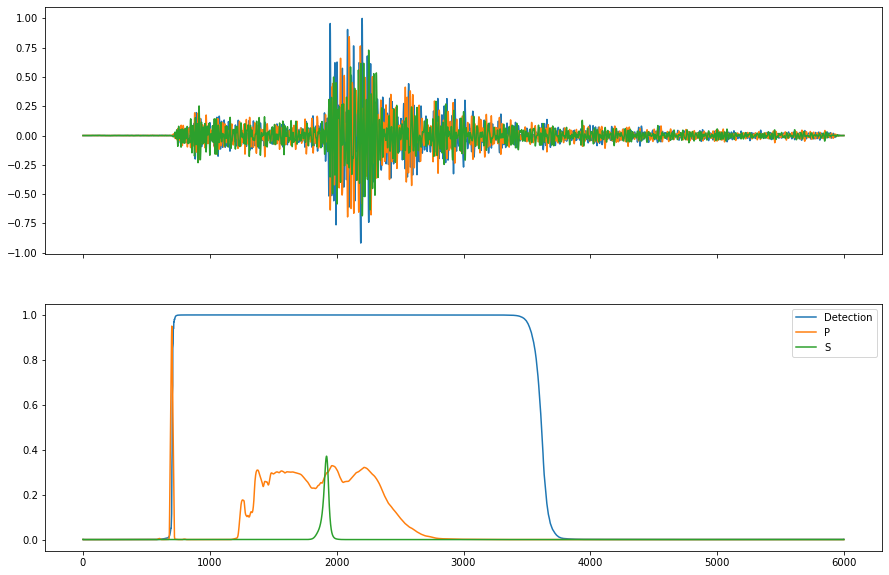

In [36]:
model.eval()
with torch.no_grad():
    det, p, s = model(torch.tensor(wv[:, [2, 1, 0]], dtype=torch.float32))
    det = det.numpy()
    p = p.numpy()
    s = s.numpy()

fig = plt.figure(figsize=(15, 10))
ax, ax2 = fig.subplots(2, 1, sharex=True)

ax.plot(wv[0, 0])
ax.plot(wv[0, 1])
ax.plot(wv[0, 2])
ax2.plot(det[0], label="Detection")
ax2.plot(p[0], label="P")
ax2.plot(s[0], label="S")
# ax2.plot(p[0] / np.max(p[0, 100:-100]), label="P")
# ax2.plot(s[0] / np.max(s[0, 100:-100]), label="S")
ax2.set_ylim(-0.05, 1.05)
ax2.legend()

# Run in an EQTransformer compatible env - results loaded

- Or hack the requirements in EQT and run here.

```python
import numpy as np
import h5py
import urllib
import matplotlib.pyplot as plt

from tempfile import NamedTemporaryFile

from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.optimizers import Adam

from EQTransformer.core.EqT_utils import SeqSelfAttention, FeedForward, f1, LayerNormalization

class DropoutMock(Dropout):
    def __init__(self, *arg, **kwargs):
        super().__init__(rate=0)

custom_objects = {'SeqSelfAttention': SeqSelfAttention, 'FeedForward': FeedForward, 'f1': f1, 'LayerNormalization': LayerNormalization, 'SpatialDropout1D': DropoutMock}
tf_model = load_model('ModelsAndSampleData/EqT_original_model.h5', custom_objects=custom_objects)

tf_model.compile(optimizer=Adam())
```

```python
temp_data = NamedTemporaryFile()
urllib.request.urlretrieve(
    "https://github.com/smousavi05/EQTransformer/raw/master/ModelsAndSampleData/100samples.hdf5",
    temp_data.name)

with h5py.File(temp_data.name, "r") as f:
    wv = f['data']['109C.TA_20060723155859_EV'][()]
    
wv -= np.mean(wv, axis=-1, keepdims=True)
wv /= np.amax(wv)
wv = wv.T.reshape(1, 3, 6000)


tf_det, tf_p, tf_s = tf_model.predict(np.transpose(wv, (0, 2, 1)))

np.save("../seisbench/contrib/model_conversion/eqt_original_det.npy", tf_det)
np.save("../seisbench/contrib/model_conversion/eqt_original_p.npy", tf_p)
np.save("../seisbench/contrib/model_conversion/eqt_original_s.npy", tf_s)
```

In [35]:
import numpy as np
import h5py
import urllib
import matplotlib.pyplot as plt

from tempfile import NamedTemporaryFile

from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.optimizers import Adam

from EQTransformer.core.EqT_utils import SeqSelfAttention, FeedForward, f1, LayerNormalization

class DropoutMock(Dropout):
    def __init__(self, *arg, **kwargs):
        super().__init__(rate=0)

custom_objects = {'SeqSelfAttention': SeqSelfAttention, 'FeedForward': FeedForward, 'f1': f1, 'LayerNormalization': LayerNormalization, 'SpatialDropout1D': DropoutMock}
temp_model = NamedTemporaryFile()
urllib.request.urlretrieve(
    "https://github.com/smousavi05/EQTransformer/raw/master/ModelsAndSampleData/EqT_original_model.h5",
    temp_model.name)
tf_model = load_model(temp_model.name, custom_objects=custom_objects)

tf_model.compile(optimizer=Adam())

# temp_data = NamedTemporaryFile()
# urllib.request.urlretrieve(
#     "https://github.com/smousavi05/EQTransformer/raw/master/ModelsAndSampleData/100samples.hdf5",
#     temp_data.name)

# with h5py.File(temp_data.name, "r") as f:
#     wv = f['data']['109C.TA_20060723155859_EV'][()]

# wv -= np.mean(wv, axis=-1, keepdims=True)
# wv /= np.amax(wv)
# wv = wv.T.reshape(1, 3, 6000)


# tf_det, tf_p, tf_s = tf_model.predict(np.transpose(wv, (0, 2, 1)))

# np.save("eqt_original_det.npy", tf_det)
# np.save("eqt_original_p.npy", tf_p)
# np.save("eqt_original_s.npy", tf_s)

2022-06-16 16:47:40.003593: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-16 16:47:40.047540: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-16 16:47:40.047880: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


2022-06-16 16:47:40.048774: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-16 16:47:40.049392: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-16 16:47:40.049666: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-16 16:47:40.049818: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so retur

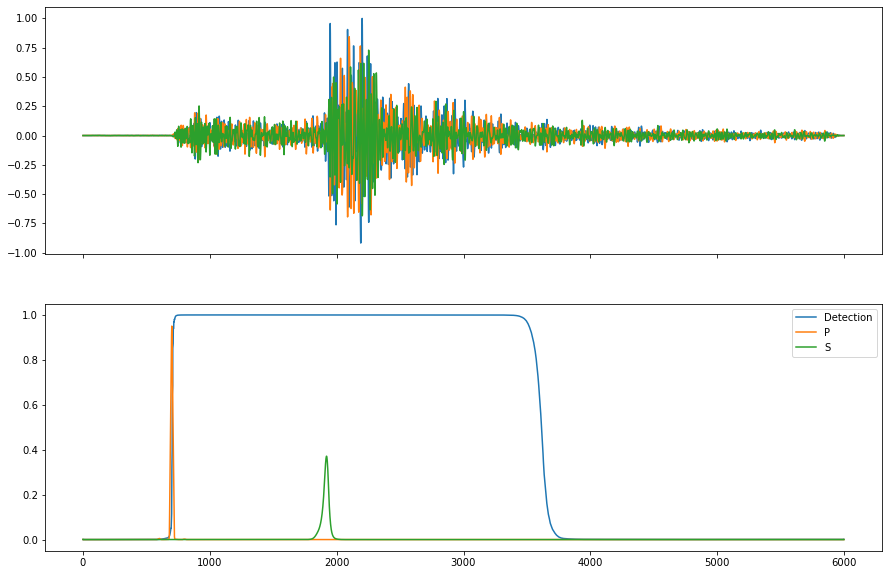

In [38]:
tf_det = np.load("eqt_original_det.npy")
tf_p = np.load("eqt_original_p.npy")
tf_s = np.load("eqt_original_s.npy")

fig = plt.figure(figsize=(15, 10))
ax, ax2 = fig.subplots(2, 1, sharex=True)

ax.plot(wv[0, 0])
ax.plot(wv[0, 1])
ax.plot(wv[0, 2])
ax2.plot(tf_det[0, :, 0], label="Detection")
ax2.plot(tf_p[0, :, 0], label="P")
ax2.plot(tf_s[0, :, 0], label="S")
ax2.set_ylim(-0.05, 1.05)
ax2.legend()

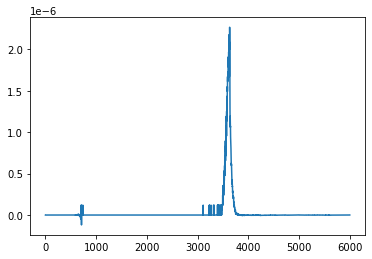

In [39]:
plt.plot(tf_det[0, :, 0] - det[0, :])

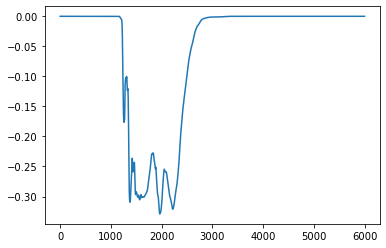

In [40]:
plt.plot(tf_p[0, :, 0] - p[0, :])

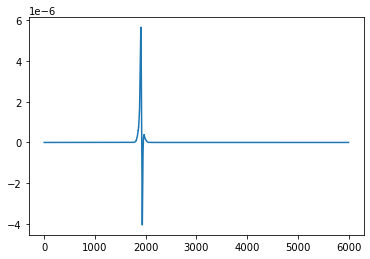

In [41]:
plt.plot(tf_s[0, :, 0] - s[0, :])

## The outputs did not match at first - whats up?

Lets try to look at the model outputs:

In [36]:
# With a Keras function
get_all_layer_outputs = K.function([tf_model.layers[0].input],
                                   [l.output for l in tf_model.layers])

layer_output = get_all_layer_outputs(np.transpose(wv, (0, 2, 1))) # return the same thing

2022-06-16 16:47:48.184120: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8201


In [37]:
len(layer_output)

148

In [38]:
len(tf_model.layers)

148

In [39]:
for i, layer in enumerate(tf_model.layers):
    print(i, layer.name)

0 input
1 conv1d_1
2 max_pooling1d_1
3 conv1d_2
4 max_pooling1d_2
5 conv1d_3
6 max_pooling1d_3
7 conv1d_4
8 max_pooling1d_4
9 conv1d_5
10 max_pooling1d_5
11 conv1d_6
12 max_pooling1d_6
13 conv1d_7
14 max_pooling1d_7
15 batch_normalization_1
16 activation_1
17 dropout_mock
18 conv1d_8
19 batch_normalization_2
20 activation_2
21 dropout_mock_1
22 conv1d_9
23 add_1
24 batch_normalization_3
25 activation_3
26 dropout_mock_2
27 conv1d_10
28 batch_normalization_4
29 activation_4
30 dropout_mock_3
31 conv1d_11
32 add_2
33 batch_normalization_5
34 activation_5
35 dropout_mock_4
36 conv1d_12
37 batch_normalization_6
38 activation_6
39 dropout_mock_5
40 conv1d_13
41 add_3
42 batch_normalization_7
43 activation_7
44 dropout_mock_6
45 conv1d_14
46 batch_normalization_8
47 activation_8
48 dropout_mock_7
49 conv1d_15
50 add_4
51 batch_normalization_9
52 activation_9
53 dropout_mock_8
54 conv1d_16
55 batch_normalization_10
56 activation_10
57 dropout_mock_9
58 conv1d_17
59 add_5
60 batch_normalizatio

In [48]:
model.eval()
with torch.no_grad():
#     det, p, s = model(torch.tensor(wv, dtype=torch.float32))
    det, p, s, layerout = model(torch.tensor(wv, dtype=torch.float32))
#     layerout = layerout.numpy()
print(layerout.shape)

(1, 16, 47)


In [52]:
layer_idx = 96
print(tf_model.layers[layer_idx])
tf_out = layer_output[layer_idx]
print(tf_out.shape)

(1, 47, 16)


In [53]:
np.allclose(layerout[0].T, tf_out[0], rtol=0.01)

False

In [54]:
layerout[0].T

array([[ 6.90194219e-02,  2.53233522e-01,  5.18084317e-02,
        -1.70176581e-01, -4.97634619e-01,  6.26514435e-01,
         6.33770764e-01, -1.67830791e-02,  1.89955279e-01,
         3.22243065e-01,  1.89302098e-02,  1.61417888e-03,
         1.64007731e-02,  6.73129380e-01,  1.16556957e-01,
        -2.80544581e-03],
       [ 1.15316138e-01,  2.74983495e-01,  1.04564331e-01,
        -3.60520273e-01, -1.66459426e-01,  7.27257431e-01,
         6.14807427e-01, -1.33752888e-02,  1.80864468e-01,
         3.36280763e-01,  5.34128249e-02, -5.38632413e-03,
         5.81719279e-02,  8.51534188e-01,  1.92909688e-01,
         1.73975542e-01],
       [ 1.38210937e-01,  2.68235952e-01,  1.54778451e-01,
        -3.56370717e-01, -5.18579669e-02,  7.18713880e-01,
         5.58421791e-01, -5.06202504e-03,  1.90138996e-01,
         3.52860481e-01,  8.43440890e-02, -8.01222306e-03,
         8.92428011e-02,  8.89737666e-01,  1.63155049e-01,
         3.31723452e-01],
       [ 1.63624957e-01,  2.60274291e

In [55]:
tf_out[0]

array([[ 7.10919723e-02,  2.42429033e-01,  5.47580682e-02,
        -1.68955058e-01, -4.85361159e-01,  6.26081586e-01,
         6.24961615e-01, -1.69248264e-02,  1.89148098e-01,
         3.24556649e-01,  1.87701210e-02,  1.47123309e-03,
         1.65225808e-02,  6.70424104e-01,  1.17984504e-01,
        -1.83700805e-03],
       [ 1.18550599e-01,  2.59931743e-01,  1.07955441e-01,
        -3.58598173e-01, -1.53264701e-01,  7.25178182e-01,
         6.07271075e-01, -1.29187591e-02,  1.81168005e-01,
         3.42581630e-01,  5.33576086e-02, -6.04732707e-03,
         5.75796142e-02,  8.49053860e-01,  1.94518119e-01,
         1.73825383e-01],
       [ 1.41693056e-01,  2.52585948e-01,  1.58447757e-01,
        -3.54116559e-01, -4.76753451e-02,  7.18907416e-01,
         5.49643695e-01, -4.40736301e-03,  1.91820055e-01,
         3.59500319e-01,  8.43472257e-02, -8.56804196e-03,
         8.84803683e-02,  8.88229668e-01,  1.61864370e-01,
         3.30917716e-01],
       [ 1.60247609e-01,  2.44712710e

In [56]:
layerout[0].T - tf_out[0]

array([[-2.07255036e-03,  1.08044893e-02, -2.94963643e-03,
        -1.22152269e-03, -1.22734606e-02,  4.32848930e-04,
         8.80914927e-03,  1.41747296e-04,  8.07181001e-04,
        -2.31358409e-03,  1.60088763e-04,  1.42945792e-04,
        -1.21807680e-04,  2.70527601e-03, -1.42754614e-03,
        -9.68437758e-04],
       [-3.23446095e-03,  1.50517523e-02, -3.39110941e-03,
        -1.92210078e-03, -1.31947249e-02,  2.07924843e-03,
         7.53635168e-03, -4.56529669e-04, -3.03536654e-04,
        -6.30086660e-03,  5.52162528e-05,  6.61002938e-04,
         5.92313707e-04,  2.48032808e-03, -1.60843134e-03,
         1.50159001e-04],
       [-3.48211825e-03,  1.56500041e-02, -3.66930664e-03,
        -2.25415826e-03, -4.18262184e-03, -1.93536282e-04,
         8.77809525e-03, -6.54662028e-04, -1.68105960e-03,
        -6.63983822e-03, -3.13669443e-06,  5.55818900e-04,
         7.62432814e-04,  1.50799751e-03,  1.29067898e-03,
         8.05735588e-04],
       [ 3.37734818e-03,  1.55615807e

In [57]:
plt.imshow(tf_out[0])

In [58]:
plt.imshow(layerout[0].T)

In [59]:
cb = plt.imshow(tf_out[0] - layerout[0].T)
plt.colorbar(cb)

In [87]:
layer = tf_model.layers[layer_idx]

In [77]:
layer.get_config()

{'name': 'layer_normalization_4',
 'trainable': True,
 'dtype': 'float32',
 'center': True,
 'scale': True,
 'epsilon': 9.999999999999998e-15,
 'gamma_initializer': {'class_name': 'Ones', 'config': {}},
 'beta_initializer': {'class_name': 'Zeros', 'config': {}}}

In [121]:
from pprint import pprint

for layer_id in range(14):
    layer = tf_model.layers[layer_id]
    print(f"{layer_id}: {layer.name}")
    pprint(layer.get_config())

0: input
{'batch_input_shape': (None, 6000, 3),
 'dtype': 'float32',
 'name': 'input',
 'ragged': False,
 'sparse': False}
1: conv1d_1
{'activation': 'relu',
 'activity_regularizer': None,
 'bias_constraint': None,
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'bias_regularizer': {'class_name': 'L1L2',
                      'config': {'l1': 9.999999747378752e-05, 'l2': 0.0}},
 'data_format': 'channels_last',
 'dilation_rate': (1,),
 'dtype': 'float32',
 'filters': 8,
 'groups': 1,
 'kernel_constraint': None,
 'kernel_initializer': {'class_name': 'VarianceScaling',
                        'config': {'distribution': 'uniform',
                                   'mode': 'fan_avg',
                                   'scale': 1.0,
                                   'seed': None}},
 'kernel_regularizer': {'class_name': 'L1L2',
                        'config': {'l1': 0.0, 'l2': 9.999999974752427e-07}},
 'kernel_size': (11,),
 'name': 'conv1d_1',
 'padding': 'same',
 'strides':